In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchinfo
import torchtext.transforms as T
from seaborn import heatmap
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.schemas import NlpContext
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.sequence_data.models.lstm import LSTMDiscriminator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.tag_prediction.controllers.trainer_bilstm_crf import BiLSTMCRFTrainer
from torchlake.tag_prediction.models.bilstm_crf import (BiLSTMCRF,
                                                        LinearCRFLoss)
from torchtext.data import get_tokenizer
from torchlake.common.utils.text import build_vocab

# setting


In [2]:
artifacts_path = Path("../../artifacts/bilstm-crf")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data/nerDataset")

In [3]:
batch_size = 128
CONTEXT = NlpContext(device="cuda:0")

In [4]:
tokenizer = get_tokenizer("basic_english")

In [5]:
DEVICE = torch.device(CONTEXT.device)

In [6]:
NUM_WORKERS = get_num_workers()

# data


In [7]:
# data = pd.read_csv(data_path.joinpath("ner_dataset.csv"), encoding="latin-1")

In [8]:
# data["Sentence #"] = data["Sentence #"].ffill()

In [9]:
# speedup groupby to save you hours to 10 seconds
# data = data.set_index("Sentence #")

In [10]:
# new_df = data.groupby(level=(0)).apply(
#     lambda row: [row["Word"].str.cat(sep=" "), row["Tag"].str.cat(sep=" ")]
# )

In [11]:
# new_df = pd.DataFrame(new_df.tolist(), columns=["Text", "Label"])

In [12]:
# new_df.to_csv(data_path.joinpath("processed.csv"), index=False)

# load text data


In [13]:
new_df = pd.read_csv(data_path.joinpath("processed.csv"))

In [14]:
# TODO: stratified so every label are present in train and test
train_data, test_data = train_test_split(new_df, test_size=1/5, random_state=32)

In [15]:
train_data

,Text,Label
2122,U Win Tin was arrested in 1989 and is serving ...,B-org I-org I-org O O O B-tim O O O O O O O O ...
1095,The last time the Vatican issued a vacant see ...,O O O O B-gpe O O O O O O O B-tim O O O B-per ...
46391,Witnesses say a top Palestinian bombmaker for ...,O O O O B-gpe O O O O B-geo I-geo O O O O B-ti...
22794,Pakistani police say a suicide bomber crashed ...,B-gpe O O O O O O O O O O O O O O O O O O O O ...
31861,The Defense Department is investigating the ac...,O B-org I-org O O O O O
...,...,...
24828,The militant Hezbollah movement fought a 34-da...,O O B-org O O O O O O B-geo O B-tim O O O O O ...
20414,The rebels say they will continue until the mo...,O O O O O O O O O O O O O O O O O O O O O
9526,The Olympic torch will make two trips to the w...,O O O O O O O O O O O O O O O O O O O O B-tim ...
42539,There were no reports of injuries and no claim...,O O O O O O O O O O O O


In [16]:
train_data["Text"].str.len().describe()

count    38367.000000
mean       125.074283
std         46.875765
min          3.000000
25%         92.000000
50%        123.000000
75%        155.000000
max        541.000000
Name: Text, dtype: float64

<Axes: title={'center': 'tag count'}, xlabel='Label'>

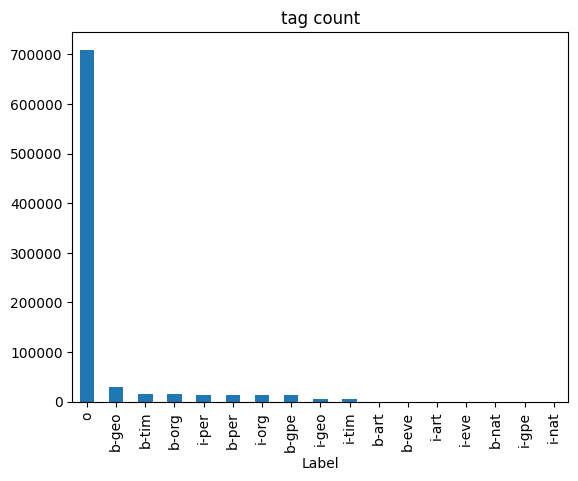

In [17]:
train_data["Label"].str.lower().str.split().explode().value_counts().plot(kind='bar', title='tag count')

In [18]:
vocab = build_vocab(
    train_data["Text"].str.lower().str.split(),
    context=CONTEXT,
)

In [19]:
label_vocab = build_vocab(
    train_data["Label"].str.lower().str.split(),
    context=CONTEXT,
)

In [20]:
VOCAB_SIZE = len(vocab)
NUM_CLASS = len(label_vocab)

In [21]:
VOCAB_SIZE, NUM_CLASS

(9104, 21)

In [22]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [23]:
label_transform = T.Sequential(
    T.VocabTransform(label_vocab),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [24]:
def collate_fn(batch: np.ndarray):
    text_placeholder, label_placeholder = [], []

    for text, label in batch:
        text = tokenizer(text)
        text = text_transform(text)
        text_placeholder.append(text)
        
        label = tokenizer(label)
        label = label_transform(label)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.stack(label_placeholder)

In [25]:
train_iter = DataLoader(
    train_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_iter = DataLoader(
    test_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
)

In [26]:
for text, label in train_iter:
    # print(text[0], label[0])
    print(text.shape, label.shape)
    break

torch.Size([128, 256]) torch.Size([128, 256])


# model


In [27]:
EMBED_DIM = 300
HIDDEN_DIM = 256

In [28]:
model = BiLSTMCRF(
    VOCAB_SIZE,
    EMBED_DIM,
    HIDDEN_DIM,
    NUM_CLASS,
    num_layers=2,
    context=CONTEXT,
).to(DEVICE)

In [29]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
BiLSTMCRF                                --
├─LSTMDiscriminator: 1-1                 --
│    └─Embedding: 2-1                    2,731,200
│    └─LSTM: 2-2                         2,719,744
│    └─LayerNorm: 2-3                    1,024
│    └─Linear: 2-4                       10,773
├─LinearCRF: 1-2                         441
Total params: 5,463,182
Trainable params: 5,463,182
Non-trainable params: 0

# training


In [125]:
EPOCHES = 30

In [126]:
trainer = BiLSTMCRFTrainer(EPOCHES, DEVICE)

In [127]:
criterion = LinearCRFLoss(crf_weight=1e-1, context=CONTEXT)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

In [128]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    "min",
    patience=2,
    threshold=0.05,
    threshold_mode="rel",
)

In [129]:
training_loss = trainer.run(
    train_iter,
    model,
    optimizer,
    criterion,
    scheduler,
)

100%|██████████| 299/299 [00:20<00:00, 14.54it/s]


epoch 1 : 1.0609367955289157


100%|██████████| 299/299 [00:19<00:00, 15.00it/s]


epoch 2 : 0.7569757955130128


100%|██████████| 299/299 [00:19<00:00, 15.02it/s]


epoch 3 : 0.6130775258094571


100%|██████████| 299/299 [00:19<00:00, 15.02it/s]


epoch 4 : 0.512219038695396


100%|██████████| 299/299 [00:20<00:00, 14.67it/s]


epoch 5 : 0.4331184236899666


100%|██████████| 299/299 [00:19<00:00, 15.07it/s]


epoch 6 : 0.3752272089687877


100%|██████████| 299/299 [00:19<00:00, 15.25it/s]


epoch 7 : 0.3318436365562139


100%|██████████| 299/299 [00:19<00:00, 15.24it/s]


epoch 8 : 0.29992062750468684


100%|██████████| 299/299 [00:19<00:00, 15.33it/s]


epoch 9 : 0.2813511369220389


100%|██████████| 299/299 [00:19<00:00, 15.31it/s]


epoch 10 : 0.2658120503892069


100%|██████████| 299/299 [00:19<00:00, 15.27it/s]


epoch 11 : 0.2596388524990018


100%|██████████| 299/299 [00:19<00:00, 15.18it/s]


epoch 12 : 0.2529548238402226


100%|██████████| 299/299 [00:19<00:00, 15.25it/s]


epoch 13 : 0.24734984106543073


100%|██████████| 299/299 [00:19<00:00, 15.18it/s]


epoch 14 : 0.24672570069597716


100%|██████████| 299/299 [00:19<00:00, 15.18it/s]


epoch 15 : 0.24234246168547252


100%|██████████| 299/299 [00:19<00:00, 15.34it/s]


epoch 16 : 0.24114500898182592


100%|██████████| 299/299 [00:19<00:00, 15.24it/s]


epoch 17 : 0.2400583629325082


100%|██████████| 299/299 [00:20<00:00, 14.34it/s]


epoch 18 : 0.23805766153993416


100%|██████████| 299/299 [00:21<00:00, 13.79it/s]


epoch 19 : 0.2350989143086915


100%|██████████| 299/299 [00:21<00:00, 14.24it/s]


epoch 20 : 0.23571821105320717


100%|██████████| 299/299 [00:20<00:00, 14.76it/s]


epoch 21 : 0.23545044224497466


100%|██████████| 299/299 [00:20<00:00, 14.49it/s]


epoch 22 : 0.2335387760879204


100%|██████████| 299/299 [00:19<00:00, 15.25it/s]


epoch 23 : 0.23565795519280194


100%|██████████| 299/299 [00:19<00:00, 15.41it/s]


epoch 24 : 0.23627165827065408


100%|██████████| 299/299 [00:19<00:00, 15.36it/s]


epoch 25 : 0.23819365646428486


100%|██████████| 299/299 [00:19<00:00, 15.40it/s]


epoch 26 : 0.23631455594779655


100%|██████████| 299/299 [00:22<00:00, 13.32it/s]


epoch 27 : 0.23430384536052629


100%|██████████| 299/299 [00:20<00:00, 14.57it/s]


epoch 28 : 0.23566616231880858


100%|██████████| 299/299 [00:19<00:00, 15.36it/s]


epoch 29 : 0.23473736297426415


100%|██████████| 299/299 [00:19<00:00, 15.38it/s]

epoch 30 : 0.2331008327794713


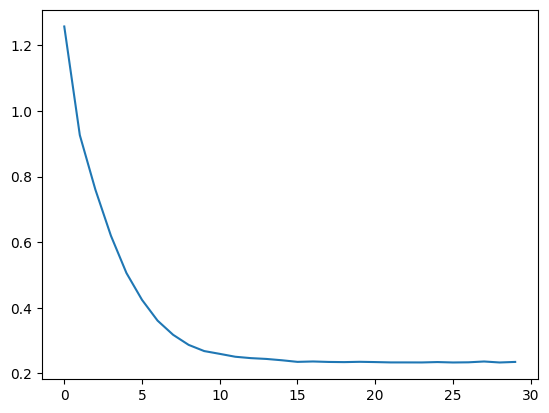

In [67]:
plt.plot(training_loss)

In [30]:
model_path = artifacts_path.joinpath("crf.pth")

In [77]:
torch.save(model.state_dict(), model_path)

In [78]:
get_file_size(model_path)

'20.84MiB'

In [31]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

## baseline

In [74]:
baseline = LSTMDiscriminator(
    VOCAB_SIZE,
    EMBED_DIM,
    HIDDEN_DIM,
    NUM_CLASS,
    num_layers=2,
    bidirectional=True,
    context=CONTEXT,
    sequence_output=True,
).to(DEVICE)

In [75]:
torchinfo.summary(baseline)

Layer (type:depth-idx)                   Param #
LSTMDiscriminator                        --
├─Embedding: 1-1                         2,731,200
├─LSTM: 1-2                              2,719,744
├─LayerNorm: 1-3                         1,024
├─Linear: 1-4                            10,773
Total params: 5,462,741
Trainable params: 5,462,741
Non-trainable params: 0

In [80]:
trainer = ClassificationTrainer(EPOCHES, DEVICE, feature_last=True)

In [81]:
criterion = nn.CrossEntropyLoss(ignore_index=CONTEXT.padding_idx)
optimizer = torch.optim.Adam(baseline.parameters(), lr=1e-3)

In [82]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    "min",
    patience=2,
    threshold=0.05,
    threshold_mode="rel",
)

In [83]:
training_loss = trainer.run(
    train_iter,
    baseline,
    optimizer,
    criterion,
    scheduler,
)

100%|██████████| 299/299 [00:18<00:00, 16.03it/s]


epoch 1 : 0.2062370120532138


100%|██████████| 299/299 [00:17<00:00, 16.71it/s]


epoch 2 : 0.10340591111410422


100%|██████████| 299/299 [00:18<00:00, 16.15it/s]


epoch 3 : 0.07775310061896924


100%|██████████| 299/299 [00:18<00:00, 16.31it/s]


epoch 4 : 0.058208013158976835


100%|██████████| 299/299 [00:18<00:00, 16.22it/s]


epoch 5 : 0.043137373296811825


100%|██████████| 299/299 [00:17<00:00, 16.62it/s]


epoch 6 : 0.031068588890459225


100%|██████████| 299/299 [00:17<00:00, 16.86it/s]


epoch 7 : 0.02205801007951482


100%|██████████| 299/299 [00:17<00:00, 16.98it/s]


epoch 8 : 0.01621586949499106


100%|██████████| 299/299 [00:17<00:00, 17.06it/s]


epoch 9 : 0.0124169275301655


100%|██████████| 299/299 [00:17<00:00, 17.03it/s]


epoch 10 : 0.009475773022849623


100%|██████████| 299/299 [00:17<00:00, 17.05it/s]


epoch 11 : 0.007984185925401423


100%|██████████| 299/299 [00:18<00:00, 15.85it/s]


epoch 12 : 0.006550975671866566


100%|██████████| 299/299 [00:17<00:00, 17.45it/s]


epoch 13 : 0.005962815229550477


100%|██████████| 299/299 [00:17<00:00, 17.43it/s]


epoch 14 : 0.005382522012817247


100%|██████████| 299/299 [00:16<00:00, 17.69it/s]


epoch 15 : 0.00479997784276197


100%|██████████| 299/299 [00:17<00:00, 17.49it/s]


epoch 16 : 0.00441340264049748


100%|██████████| 299/299 [00:17<00:00, 17.34it/s]


epoch 17 : 0.00434203200582664


100%|██████████| 299/299 [00:16<00:00, 17.62it/s]


epoch 18 : 0.00420728836494364


100%|██████████| 299/299 [00:17<00:00, 17.55it/s]


epoch 19 : 0.00386979706611883


100%|██████████| 299/299 [00:17<00:00, 17.35it/s]


epoch 20 : 0.0034159990786777244


100%|██████████| 299/299 [00:17<00:00, 17.44it/s]


epoch 21 : 0.0037656747041048986


100%|██████████| 299/299 [00:17<00:00, 17.58it/s]


epoch 22 : 0.003413185635721778


100%|██████████| 299/299 [00:18<00:00, 16.60it/s]


epoch 23 : 0.0033652905589296642


100%|██████████| 299/299 [00:18<00:00, 16.41it/s]


epoch 24 : 0.0020929588479757697


100%|██████████| 299/299 [00:18<00:00, 16.35it/s]


epoch 25 : 0.001207593053197379


100%|██████████| 299/299 [00:18<00:00, 16.50it/s]


epoch 26 : 0.001100526814471446


100%|██████████| 299/299 [00:18<00:00, 16.50it/s]


epoch 27 : 0.0010889031232044998


100%|██████████| 299/299 [00:18<00:00, 16.58it/s]


epoch 28 : 0.0010574801730107474


100%|██████████| 299/299 [00:18<00:00, 16.52it/s]


epoch 29 : 0.0010502855395717662


100%|██████████| 299/299 [00:18<00:00, 16.41it/s]

epoch 30 : 0.0010085543289214698


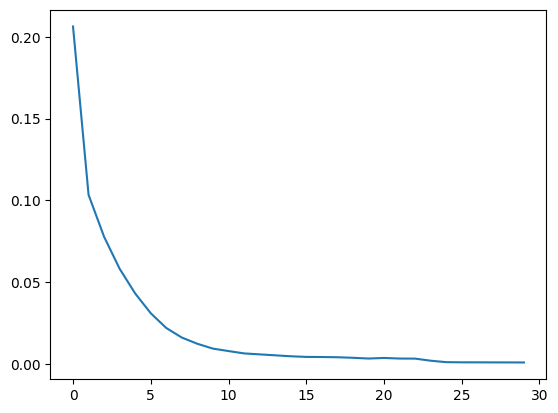

In [84]:
plt.plot(training_loss)

In [85]:
baseline_path = artifacts_path.joinpath("baseline.pth")

In [86]:
torch.save(baseline.state_dict(), baseline_path)

In [87]:
get_file_size(baseline_path)

'20.84MiB'

In [88]:
baseline.load_state_dict(torch.load(baseline_path))

<All keys matched successfully>

# prediction


In [34]:
# 1, S, O
node_potential = model.foot(x).log_softmax(-1)

In [35]:
model.forward(x)

tensor([[1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2]], device='cuda:0')

In [36]:
# 1, O, O
transition_score = model.head.transition.unsqueeze(0).log_softmax(-1)

In [41]:
label_vocab.lookup_indices(tag.lower().split())

[11, 4, 4, 4, 4, 4, 4, 7, 10, 4, 4, 4, 7, 10, 4, 4, 4, 4, 4, 4, 5, 4]

In [37]:
mask = x.eq(CONTEXT.padding_idx)
backpointers = []


# forward
backpointers = []

# P(Y0)
# B, O, 1
alpha = torch.randn((batch_size, NUM_CLASS, 1)).to(DEVICE)
# start from bos
alpha[:, CONTEXT.bos_idx, :] = 3
alpha[:, CONTEXT.eos_idx, :] = -3
alpha[:, CONTEXT.padding_idx, :] = -3
alpha = alpha.log_softmax(1)

# alpha = P(Y1, Y0 | x) = P(Y1|x) * P(Y0)
alpha += node_potential[:, 0, :, None]

for t in range(1, CONTEXT.max_seq_len):
    # batch_size, next_tag, current_tag -> B, O, 1 + 1, O, O
    # P(Y2|Y1) * P(Y1, Y0 | x)
    posterior_t = alpha + transition_score
    posterior_t += node_potential[:, t, :]

    # find most likely next tag
    # B, O
    # P(Y2, Y1=y1, Y0 | x)
    posterior_t, bkptr_t = posterior_t.max(dim=-1)
    print(posterior_t[0])
    print(bkptr_t[0])

    # P(Y2|x) * P(Y2, Y1=y1, Y0 | x)
    # B, O
    print(posterior_t[0])
    # S-1 x (B, O)
    backpointers.append(bkptr_t)

    # mask padding token
    if mask is not None:
        # B, 1, 1
        mask_t = mask[:, t : t + 1, None].int()
    else:
        mask_t = torch.zeros((batch_size, 1, 1)).to(DEVICE)

    # B, O, 1
    alpha = posterior_t.unsqueeze(-1) * (1 - mask_t) + alpha * mask_t

best_score, best_path = alpha.max(dim=1)


tensor([-39.8763,  -3.5838, -31.2249, -44.2271, -44.0701, -40.1905, -40.4884,
        -35.9142, -35.0593, -38.5002, -41.5047, -37.1652, -41.2518, -40.1513,
        -45.0753, -43.9929, -41.6342, -34.9040, -44.3795, -41.3455, -41.1619],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11], device='cuda:0')
tensor([-39.8763,  -3.5838, -31.2249, -44.2271, -44.0701, -40.1905, -40.4884,
        -35.9142, -35.0593, -38.5002, -41.5047, -37.1652, -41.2518, -40.1513,
        -45.0753, -43.9929, -41.6342, -34.9040, -44.3795, -41.3455, -41.1619],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-41.9337,  -3.9223, -35.0065, -50.3727, -44.2120, -40.3875, -40.7165,
        -36.6110, -35.3923, -39.9880, -42.1884, -37.3374, -41.4015, -40.5467,
        -46.7066, -44.9108, -43.0243, -38.6668, -45.1167, -43.7536, -45.3382],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([4, 4, 4, 4, 4, 4

In [32]:
model.eval()
with torch.no_grad():
    for i, (_, row) in enumerate(test_data.iterrows()):
        sentence, tag = row['Text'], row['Label']
        tokenized_tag = tokenizer(tag)
        
        x = text_transform(tokenizer(sentence)).unsqueeze(0).to(DEVICE)
        tag_seq, score = model.forward(x, output_score=True)
        tag_seq = tag_seq.long().detach().cpu().flatten().tolist()
        decoded_seq = label_vocab.lookup_tokens(tag_seq)
        
        print("--------------sentence", i)
        print("score: ", score.item())
        print("pred : ", *[f"{d:<5}" for d in decoded_seq[:len(tokenized_tag)]])
        print("label: ", *[f"{t:<5}" for t in tokenized_tag])
        print("text : ", sentence)
        if i > 10:
            break

--------------sentence 0
score:  -45.018123626708984
pred :  <bos> b-per o     o     o     o     b-tim i-tim o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o    
label:  b-per o     o     o     o     b-tim i-tim o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o    
text :  Wielgus resigned his post on January 7 , after a church commission said it found numerous documents confirming the cleric had collaborated with communist security organizations for years .
--------------sentence 1
score:  -35.37142562866211
pred :  <bos> b-geo o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o    
label:  b-geo o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o    
text :  Iran 's air force also has Russian-made Sukhoi warplanes and recently 

In [55]:
baseline.eval()
with torch.no_grad():
    for i, (_, row) in enumerate(test_data.iterrows()):
        sentence, tag = row['Text'], row['Label']
        x = text_transform(tokenizer(sentence)).unsqueeze(0).to(DEVICE)
        score = baseline(x).detach().cpu()
        tag_seq = score.argmax(-1).numpy().flatten().tolist()
        decoded_seq = label_vocab.lookup_tokens(tag_seq[:len(sentence.split())])
        print("--------------sentence", i)
        print("pred : ", *[f"{d:<5}" for d in decoded_seq])
        print("label: ", *[f"{t:<5}" for t in tokenizer(tag)])
        print("text : ", sentence)
        print()
        if i > 10:
            break

--------------sentence 0
pred :  <bos> b-org i-org i-org o     o     o     b-tim o     o     o     o     o     o     o     o     o     o    
label:  b-org i-org i-org o     o     o     b-tim o     o     o     o     o     o     o     o     o     o     o    
text :  U Win Tin was arrested in 1989 and is serving a 20-year sentence for writing anti-government propaganda .

--------------sentence 1
pred :  <bos> o     o     o     o     b-gpe o     o     o     o     o     o     o     b-tim o     o     o     b-per i-per i-per o    
label:  o     o     o     o     b-gpe o     o     o     o     o     o     o     b-tim o     o     o     b-per i-per i-per o     o    
text :  The last time the Vatican issued a vacant see stamp was in 1978 , when Pope John Paul I died .

--------------sentence 2
pred :  <bos> o     o     o     o     b-gpe o     o     o     o     b-geo i-geo o     o     o     o     b-tim o     o     b-gpe o     o     o     b-geo i-geo
label:  o     o     o     o     b-gpe o     o   

# Evaluation


## model

In [38]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE, feature_dim=-1)

In [39]:
confusion_matrix = evaluator.run(test_iter, model.foot)

100%|██████████| 75/75 [00:08<00:00,  8.99it/s]

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0 9592    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0 9270    0  310    3    0    0    2    0    0    2    3    2
     0    0    0    0    0    0    0]
 [   0    0 9592    0 1602    2    1    0    0    2    0    0    0    1
     0    0    0    0    0    0    0]
 [   0    0  455    0 9590  392  281  383  128  256  313   84   92  109
    10    7    1   10    7    4    3]
 [   0    0   19    0  555 4198   27  314   33  105   24   53   71    3
     3    4    0    0    1    1    0]
 [   0    0    4    0  463   46 3108    7    7    9    5    1    3   76
     1    3    0    0    0    0    0]
 [   0    0    5    0  645  494   12 2116   48  148   73   46    4    4
     8    2    0    2    0    0    0]
 [   0    0    4    0  175   14    2   31 1886  140  104    2   38    3
     0    0    1    0    0    0    0]
 [   0    

In [40]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(label_vocab.get_itos(), per_class_acc)

<unk>     : 0.0
<bos>     : 1.0
<eos>     : 0.9664303586321935
<pad>     : 0.0
o         : 0.7909278350515464
b-geo     : 0.7758270190352985
b-tim     : 0.8325743369943746
b-org     : 0.5866370945383975
i-per     : 0.7858333333333334
b-per     : 0.7383304940374787
i-org     : 0.5469348659003831
b-gpe     : 0.8868135973104221
i-geo     : 0.6814362108479756
i-tim     : 0.6645502645502646
b-art     : 0.1044776119402985
b-eve     : 0.30303030303030304
i-art     : 0.023255813953488372
i-eve     : 0.125
b-nat     : 0.38636363636363635
i-gpe     : 0.5510204081632653
i-nat     : 0.3333333333333333


d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\common\controller\evaluator.py:110: RuntimeWarning: invalid value encountered in divide
  return np.where(total == 0, 0, hits / total)


In [41]:
per_class_acc[4:].mean()

0.5362556563755176

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\common\controller\evaluator.py:129: RuntimeWarning: invalid value encountered in divide
  percentage = np.where(total == 0, 0, hits / total)


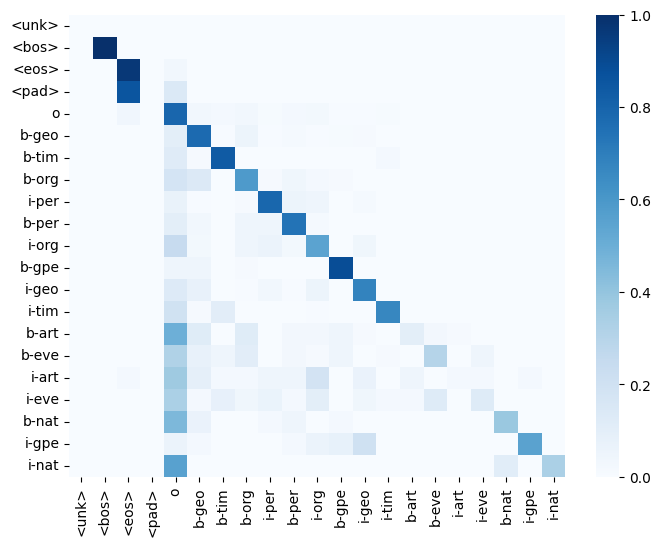

In [43]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    label_vocab.get_itos(),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

## baseline

In [89]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE, feature_dim=-1)

In [90]:
confusion_matrix = evaluator.run(test_iter, baseline)

100%|██████████| 75/75 [00:05<00:00, 14.57it/s]

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0 9592    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0 9282    0  293    7    4    0    2    0    1    0    1    2
     0    0    0    0    0    0    0]
 [   0    0 9592    0 1163    0    0    0    0    0    0    0    1    2
     0    0    0    0    0    0    0]
 [   0    0  447    0 9590  385  236  388  157  240  327   89   96  138
     7    5    4    6    4    2    2]
 [   0    0   23    0  577 4206   30  308   34   96   31   55   53    4
     2    1    0    0    1    0    0]
 [   0    0    5    0  463   44 3098    9    7    6    9    1    1   73
     1    1    0    1    0    0    0]
 [   0    0    6    0  663  465   18 2116   53  158   80   48    8    2
     5    3    1    2    0    0    0]
 [   0    0    4    0  165   12    4   29 1904  132  101    2   27    4
     0    0    2    0    0    1    0]
 [   0    

In [91]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(label_vocab.get_itos(), per_class_acc)

<unk>     : 0.0
<bos>     : 1.0
<eos>     : 0.9676814011676397
<pad>     : 0.0
o         : 0.7910583188979625
b-geo     : 0.7758716104039846
b-tim     : 0.8330196289325087
b-org     : 0.5832414553472988
i-per     : 0.7976539589442815
b-per     : 0.7366086659843057
i-org     : 0.5378429517502366
b-gpe     : 0.8858634837747109
i-geo     : 0.6704892966360856
i-tim     : 0.6610526315789473
b-art     : 0.05714285714285714
b-eve     : 0.2878787878787879
i-art     : 0.0
i-eve     : 0.1956521739130435
b-nat     : 0.3409090909090909
i-gpe     : 0.5416666666666666
i-nat     : 0.1111111111111111


d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\common\controller\evaluator.py:110: RuntimeWarning: invalid value encountered in divide
  return np.where(total == 0, 0, hits / total)


In [92]:
per_class_acc[4:].mean()

0.518062511168934

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\common\controller\evaluator.py:129: RuntimeWarning: invalid value encountered in divide
  percentage = np.where(total == 0, 0, hits / total)


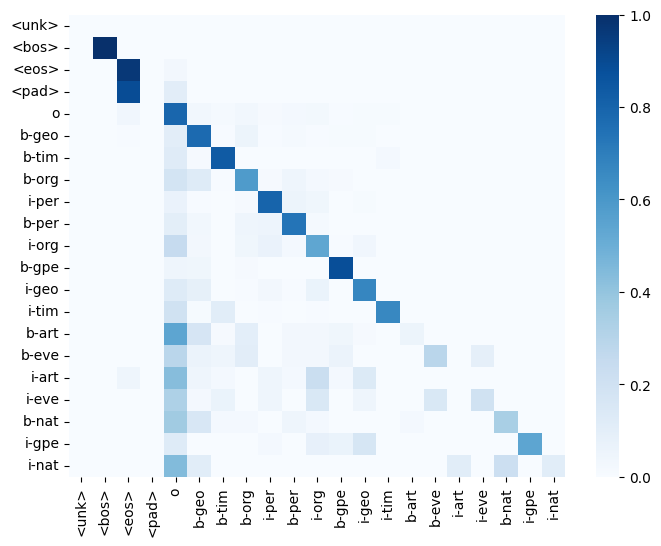

In [93]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    label_vocab.get_itos(),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

# Visualization


<Axes: title={'center': 'transition probability'}>

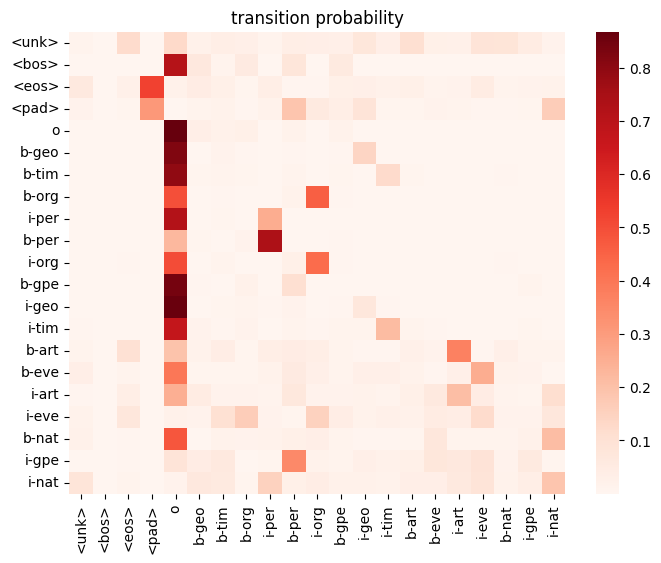

In [33]:
plt.figure(figsize=(8, 6))
plt.title('transition probability')
heatmap(
    model.head.transition
    .softmax(-1)
    .clone()
    .detach()
    .cpu()
    .numpy(),
    xticklabels=label_vocab.get_itos(),
    yticklabels=label_vocab.get_itos(),
    cmap="Reds",
)

<Axes: title={'center': 'transition probability'}>

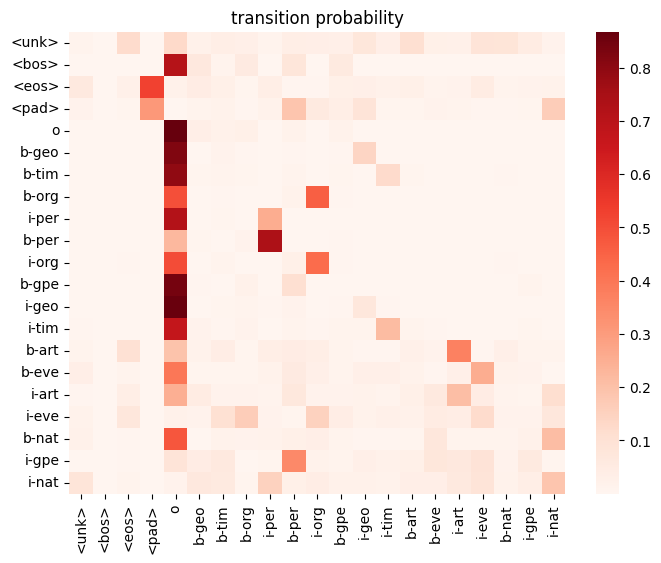

In [73]:
plt.figure(figsize=(8, 6))
plt.title('transition probability')
heatmap(
    model.head.transition
    .softmax(-1)
    .clone()
    .detach()
    .cpu()
    .numpy(),
    xticklabels=label_vocab.get_itos(),
    yticklabels=label_vocab.get_itos(),
    cmap="Reds",
)